In [2]:
import control
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (10, 5)

In [11]:
def my_root_locus(G, kvect=None):
    "custom function for plotting rlocus, control library version is problematic"
    rlist, klist = control.rlocus(G, kvect=kvect, plot=False);
    poles = control.pole(G)
    zeros = control.zero(G)
    plt.plot(np.real(rlist), np.imag(rlist));
    plt.plot(np.real(poles), np.imag(poles), '.', ms=10, marker='x', mew=1, label='open loop poles')
    plt.plot(np.real(zeros), np.imag(zeros), '.', ms=10, marker='o', mew=1, label='open loop zeros')
    r0, k0 = control.rlocus(G, kvect=[1], plot=False);
    plt.plot(np.real(r0[0]), np.imag(r0[0]), '.', ms=10, marker='s', fillstyle='none', mew=1, label='closed loop poles');
    plt.xlabel('Re')
    plt.ylabel('Im')
    plt.grid();
    plt.legend()
    plt.axis('equal')

# Fan Model

Fan 1st order plant model, taking into account spool up time.

$G_{fan} = \dfrac{F}{u_{fan}} = F_{max} \dfrac{\tau}{s + \tau}$

where:

* $F_{max}$ is the fan maximum thrust
* $\tau$ is the spool up/spool down time for the fan, assumed to be the same here
* $u_{fan}$ is the normalized [0-1] throttle command for the fan

In [12]:
tau = 10
thrust_max = 10
s = control.tf([1, 0], [1])
G_fan = thrust_max*(tau/(s+tau))
G_fan

TransferFunction(array([100.]), array([ 1, 10]))

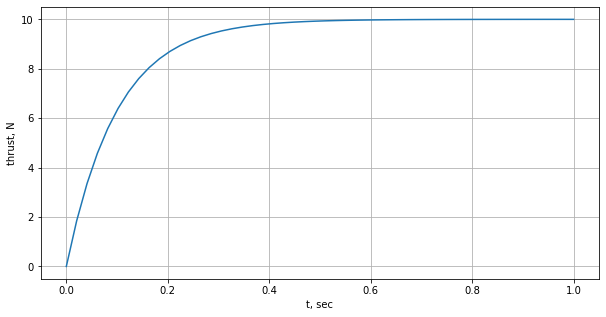

In [13]:
t, y = control.step_response(G_fan, T=np.linspace(0, 1));
plt.plot(t, y)
plt.xlabel('t, sec')
plt.ylabel('thrust, N')
plt.grid()

# Kinematic Model of Aicraft Roll

$M = J_{xx} \ddot{\phi}$

$M = J_{xx} s^2 \Phi$

$G_{roll} = \dfrac{\Phi}{M} = \dfrac{1}{J_{xx} s^2}$

# Mixing

$M = l(F_l - F_r)$

$M = l(G_{fan}u_{l} - G_{fan} u_{r})$

$u_{roll} = u_{l} - u_{r}$

$\dfrac{M}{u_{roll}} = l G_{fan}$

where:

* $l$ is the distance from the center of mass to the left and right lift fans, assumed to be at the same distance
* $F_{l/r}$ is the thrust of the left/right lift fan
* $u_{l/r}$ is the normalized [0-1] throttle command for the left/right lift fan
* $u_{roll}$ is the normalized [0-1] roll mix that we define

# Plant Model

$G = \dfrac{\Phi}{u_{roll}} =  \dfrac{\Phi}{M} \times \dfrac{M}{u_{roll}} = \dfrac{l G_{fan}}{J_{xx} s^2} = \dfrac{lF_{max}\tau}{J_{xx}s^2(s+\tau)}$

In [36]:
l = 1
J_xx = 1
Gk = 1/(J_xx*s**2)  # Plant for the "k"inematics
Gf = l*G_fan  # Plant for the "f"an
G = Gf * Gk
G

TransferFunction(array([100.]), array([ 1., 10.,  0.,  0.]))

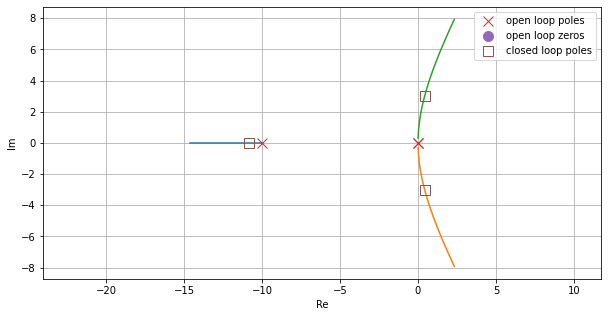

In [15]:
my_root_locus(G, kvect=np.logspace(-2, 1, 1000));

# PID controller

We will do the controller design with MATLAB SIMULINK

The design requirements for the system will be defined to be the following for a step response 
$\zeta =0\ldotp 7071$

$t_s =1\ldotp 0\;s$

Which imply 

$\%OS=exp{\left(\frac{-\zeta \pi }{\sqrt{1-\zeta {\;}^2 }}\right)}\times 100 = 4.3217 \%$

$\mathrm{t}\mathrm{i}\mathrm{m}\mathrm{e}\phantom{-}\mathrm{c}\mathrm{o}\mathrm{n}\mathrm{s}\mathrm{t}\mathrm{a}\mathrm{n}\mathrm{t}\mathrm{ }\;:=\mathrm{ }\;\;{4.6}\tau \;\;=t_s \le 1.0 s$
$\Rightarrow \tau \le 0.2174\ \ s\ \ \ldotp$


Now using the Control System Tuner of MATLAB we can design a PID with the following gains 

$K_p +K_i \frac{1}{s}+K_d \frac{s}{T_f s+1}$

<span style="color:red">CAUTION: THESE VALUES CORRESPOND TO THE PARAMETERS THAT PROF GOPPERT SET!</span>

$where \phantom{-} K_p =1.8148\text{e}-5, \phantom{-} K_i =1.8117\text{e}-10,\phantom{-} K_d =0.3130,\phantom{-} T_f =0.0421$

for the system without the noise and disturbance included during the tuning

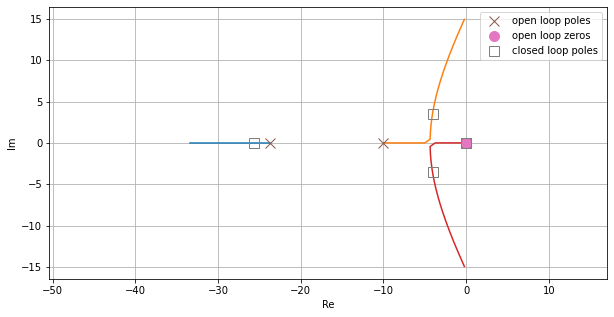

In [24]:
# H = 0.29*(s/1 + 1)/(s/30 + 1)  # lead-lag

kp = 1.81481547825078e-05 
ki = 1.81171194402346e-12
kd = 0.3129809309805
N = 23.7738638769895
H = kp + ki / s + kd * (N / (1 + N * (1 / s)))

my_root_locus(G*H, np.logspace(-10, 1, 1000))

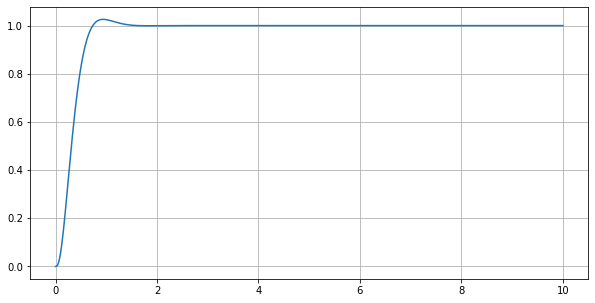

In [25]:
y_r = G*H/(1 + G*H)
t, y = control.step_response(y_r, T=np.linspace(0, 10, 1000))
plt.plot(t, y)
plt.grid()

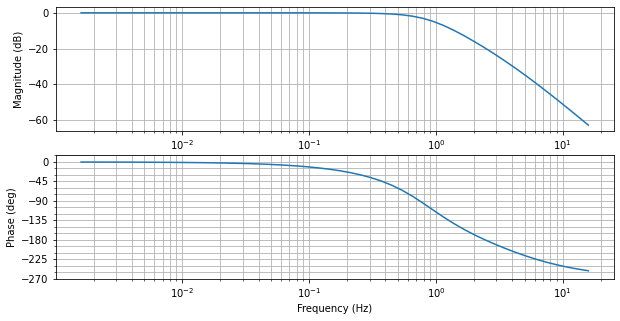

In [26]:
control.bode(y_r, omega=np.logspace(-2, 2), Hz=True, dB=True);

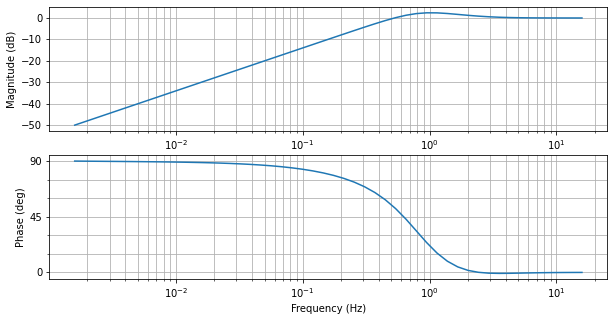

In [27]:
e_r = 1/(1 + G*H)
control.bode(e_r, omega=np.logspace(-2, 2), Hz=True, dB=True);

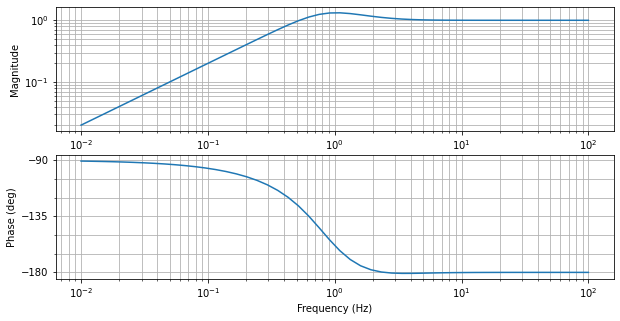

In [28]:
e_n = -1/(1 + Gk*Gf*H)
control.bode(e_n, omega=2*np.pi*np.logspace(-2, 2), Hz=True);

The maximum magnitude is (dB)
1.3199025374719187
The corresponding frequency is (rad/s)
5.963623316594643


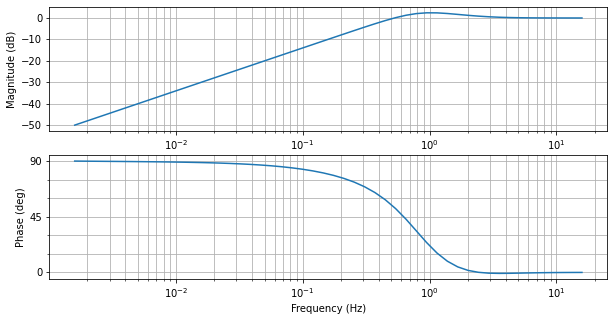

In [29]:
e_d = 1/(1 + G*H)
mag, phase, omega = control.bode(e_d, omega=np.logspace(-2, 2), Hz=True, dB=True);

mag = np.array(mag)
omega = np.array(omega)
max_idx = np.argmax(mag)
print("The maximum magnitude is (dB)")
print(mag[max_idx])
print("The corresponding frequency is (Hz)")
print(omega[max_idx])

# Gang of 4

* $\dfrac{GH}{1 + GH}$ the complementary sensitivity function
* $\dfrac{G}{1 + GH}$ the load disturbance sensitivity function
* $\dfrac{H}{1 + GH}$ the noise sensitivity function
* $\dfrac{1}{1 + GH}$ the sensitivity function

# Yaw Control 

Since the pitch control of the 2 front engines are controlled by motors we can approximate the model for those controls as a first order transfer function as follows.

$$
G_p = 
\begin{cases}
    G_{lp} = \dfrac{\theta_l}{u_{lp}} = \theta_{max} \dfrac{\tau_p}{s+\tau_p}\\
    G_{rp} = \dfrac{\theta_r}{u_{rp}} = \theta_{max} \dfrac{\tau_p}{s+\tau_p}
\end{cases}
$$

where 

$$
\begin{align}
    \theta_l &:= \text{pitch angle for left engine}\\
    \theta_r &:= \text{pitch angle for right engine }\\
    u_{lp} &:= \text{left engine angle command normalized to [0,1]}\\
    u_{rp} &:= \text{right engine angle command normalized to [0,1]}\\
    \theta_{max} &:= \text{maximum angle for the engine pitch}\\
    \tau_p &:= time constant for the pitch controlling motor
\end{align}
$$

In [37]:
tau_p = 4
theta_max = 0.7854  # radians 
s = control.tf([1, 0], [1])
G_p = theta_max*(tau_p/(s+tau_p))
G_p

TransferFunction(array([3.1416]), array([1, 4]))

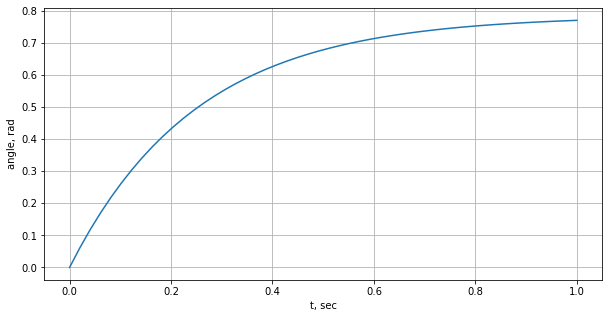

In [33]:
t, y = control.step_response(G_p, T=np.linspace(0, 1));
plt.plot(t, y)
plt.xlabel('t, sec')
plt.ylabel('angle, rad')
plt.grid()

## Kinematic Model of Aicraft Roll

$M = J_{zz} \ddot{\psi}$

$M = J_{zz} s^2 \Psi$

$G_{yaw} = \dfrac{\Psi}{M} = \dfrac{1}{J_{zz} s^2}$

## Mixing 

$M = l(F_r\sin{\theta_r} - F_l\sin{\theta_l})$

say $F = F_r = F_l =$ const.

and also $\sin{\theta} \approx \theta$

$M \approx lF(\theta_r - \theta_l)$

$M = lF(G_p u_{rp} - G_p u_{lp}) $ 

$u_{yaw} = u_{rp} - u_{lp}$

$\dfrac{M}{u_{yaw}} = l F G_{p}$

## Plant Model 

$ G = \dfrac{\Psi}{u_{yaw}} = \dfrac{\Psi}{M} \times \dfrac{M}{u_{yaw}} = \dfrac{lF\theta_{max}\tau_p}{J_{zz}s^2(s+\tau_p)} $

In [38]:
l = 1
F = 10   # constant thrust
J_zz = 1
Gyaw = 1/(J_zz*s**2)  # Plant for the "k"inematics
G = Gyaw * l * F * G_p
G

TransferFunction(array([31.416]), array([1., 4., 0., 0.]))

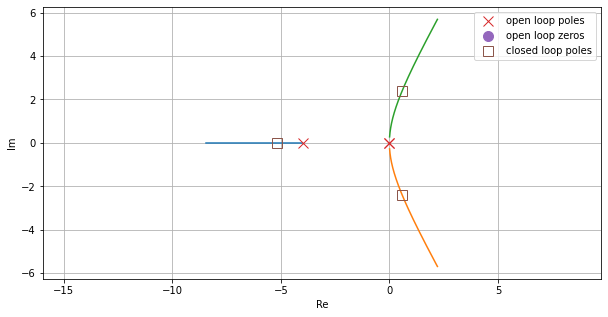

In [39]:
my_root_locus(G, kvect=np.logspace(-2, 1, 1000));

# PID controller

We will do the controller design with MATLAB SIMULINK

The design requirements for the system will be defined to be the following for a step response 
$\zeta =0\ldotp 7071$

$t_s =1\ldotp 0\;s$

Which imply 

$\%OS=exp{\left(\frac{-\zeta \pi }{\sqrt{1-\zeta {\;}^2 }}\right)}\times 100 = 4.3217 \%$

$\mathrm{t}\mathrm{i}\mathrm{m}\mathrm{e}\phantom{-}\mathrm{c}\mathrm{o}\mathrm{n}\mathrm{s}\mathrm{t}\mathrm{a}\mathrm{n}\mathrm{t}\mathrm{ }\;:=\mathrm{ }\;\;{4.6}\tau \;\;=t_s \le 1.0 s$
$\Rightarrow \tau \le 0.2174\ \ s\ \ \ldotp$


Now using the Control System Tuner of MATLAB we can design a PID with the following gains 

$K_p +K_i \frac{1}{s}+K_d \frac{s}{T_f s+1}$

<span style="color:red">CAUTION: THESE VALUES CORRESPOND TO THE PARAMETERS THAT PROF GOPPERT SET!</span>

$where \phantom{-} K_p =9.37\text{e}-8, \phantom{-} K_i =5.08\text{e}-11,\phantom{-} K_d =0.4683,\phantom{-} T_f =0.00543$

for the system without the noise and disturbance included during the tuning

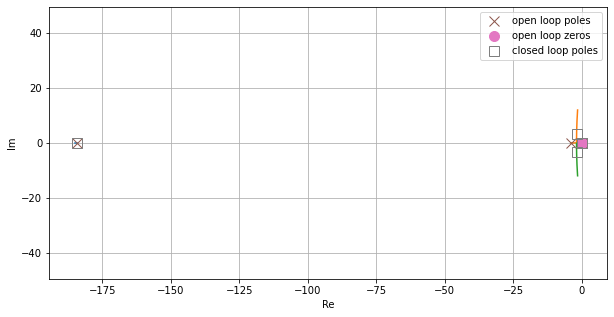

In [40]:
# H = 0.29*(s/1 + 1)/(s/30 + 1)  # lead-lag

kp = 9.36743389908816e-08  
ki = 5.08261650479512e-11 
kd = 0.468303052208702
N = 184.314581201354
H = kp + ki / s + kd * (N / (1 + N * (1 / s)))

my_root_locus(G*H, np.logspace(-10, 1, 1000))

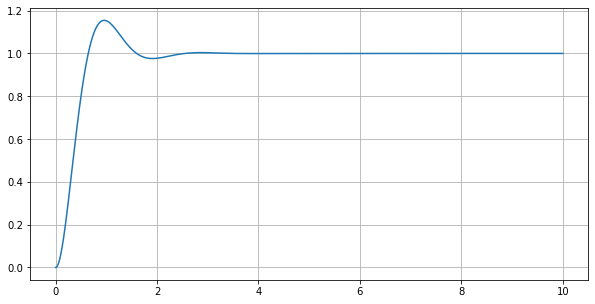

In [41]:
y_r = G*H/(1 + G*H)
t, y = control.step_response(y_r, T=np.linspace(0, 10, 1000))
plt.plot(t, y)
plt.grid()

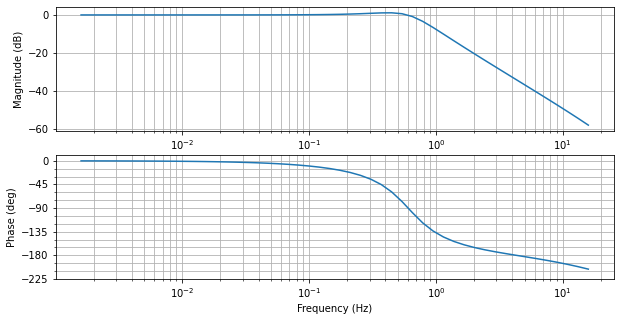

In [42]:
control.bode(y_r, omega=np.logspace(-2, 2), Hz=True, dB=True);

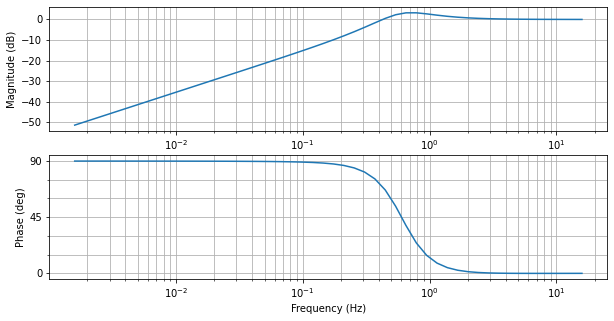

In [43]:
e_r = 1/(1 + G*H)
control.bode(e_r, omega=np.logspace(-2, 2), Hz=True, dB=True);

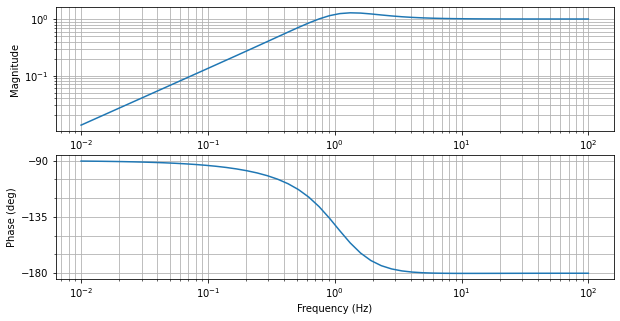

In [44]:
e_n = -1/(1 + Gk*Gf*H)
control.bode(e_n, omega=2*np.pi*np.logspace(-2, 2), Hz=True);

The maximum magnitude is (dB)
1.4495780970005685
The corresponding frequency is (Hz)
4.941713361323833


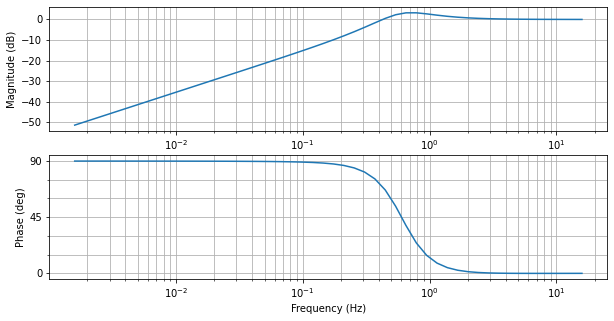

In [45]:
e_d = 1/(1 + G*H)
mag, phase, omega = control.bode(e_d, omega=np.logspace(-2, 2), Hz=True, dB=True);

mag = np.array(mag)
omega = np.array(omega)
max_idx = np.argmax(mag)
print("The maximum magnitude is (dB)")
print(mag[max_idx])
print("The corresponding frequency is (Hz)")
print(omega[max_idx])

## Pitch Control 

From the mixing matrix we know that 

For the back engine we consider

$M = l(F_l + F_r - F_b)$

where $F_b$ is the back engine 

$G_{back} = \dfrac{F}{u_{back}} = F_{b,max} \dfrac{\tau_b}{s + \tau_b}$

$M = l(G_{fan}u_{l} + G_{fan} u_{r} - G_{back} u_{b})$

$u_{roll} = u_{l} + u_{r} - u_{b}$

$\dfrac{M}{u_{roll}} = l G_{fan}$